# RNN Sentiment Analysis on IMDB Dataset

This notebook implements a Recurrent Neural Network (RNN) using LSTM (Long Short-Term Memory) layers for sentiment analysis on the IMDB movie reviews dataset. We'll preprocess 50,000 movie reviews, build a vocabulary, and create a deep learning model that learns to automatically classify whether a review expresses positive or negative sentiment, achieving 85.47% accuracy on the test set.

## 1. Data Loading and Preparation

In [1]:
from datasets import load_dataset

dataset = load_dataset("imdb")
train_dataset = dataset['train']
test_dataset = dataset['test']


In [2]:
train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [3]:
from torch.utils.data.dataset import random_split
import torch
torch.manual_seed(1)
train_dataset, valid_datasets = random_split(
    list(train_dataset), [20000, 5000]
)

## 2. Text Preprocessing and Tokenization

In [4]:
import re
from collections import Counter, OrderedDict

def tokenizer(text):
    text = re.sub(r'<[^>]*>', '', text)  # Remove HTML tags
    emoticons = re.findall(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())  # Find emoticons
    text = re.sub(r'[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')  # Remove non-word chars
    tokenized = text.split()
    return tokenized

In [5]:
token_counts = Counter()
for item in train_dataset:
    text = item['text']  
    label = item['label']  
    tokens = tokenizer(text)
    token_counts.update(tokens)
    
print('Vocab-size:', len(token_counts))

Vocab-size: 69023


In [6]:
from collections import OrderedDict


sorted_by_freq_tuples = sorted(
    token_counts.items(), key=lambda x: x[1], reverse=True
)
ordered_dict = OrderedDict(sorted_by_freq_tuples)


vocab = OrderedDict()


for token, freq in ordered_dict.items():
    vocab[token] = len(vocab)


temp_vocab = OrderedDict()
temp_vocab["<pad>"] = 0
temp_vocab["<unk>"] = 1


for token, idx in vocab.items():
    temp_vocab[token] = idx + 2


vocab = temp_vocab


default_index = 1  # <unk> index


def get_indices(tokens):
    if isinstance(tokens, str):
        return vocab.get(tokens, default_index)
    elif isinstance(tokens, list):
        return [vocab.get(token, default_index) for token in tokens]




In [7]:
print([vocab[token] for token in ['this', 'is', 'an', 'example']])

[11, 7, 35, 457]


## 3. Data Loading and Batching

In [30]:
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for item in batch:
        
        if isinstance(item, dict):
            _text = item['text']
            _label = item['label']
        else:
            
            _text, _label = item
            
        label_list.append(float(_label))  
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        lengths.append(processed_text.size(0))
        
    label_list = torch.tensor(label_list)
    lengths = torch.tensor(lengths)
    padded_text_list = nn.utils.rnn.pad_sequence(text_list, batch_first=True)
    return padded_text_list, label_list, lengths

text_pipeline = lambda x: get_indices(tokenizer(x))

In [31]:
batch_size = 32
train_dl = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,collate_fn=collate_batch)
valid_dl = DataLoader(valid_datasets,batch_size=batch_size,shuffle=False,collate_fn=collate_batch)
test_dl =  DataLoader(test_dataset,batch_size=batch_size,shuffle=False,collate_fn=collate_batch)

In [32]:
len(train_dl)

625

In [33]:
import torch.nn as nn


## 4. Model Architecture

In [34]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embd_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embd_dim,padding_idx=0)
        self.rnn = nn.LSTM(embd_dim, rnn_hidden_size, batch_first= True)
        self.fc1 = nn.Linear(rnn_hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self,text,lengths):
        out = self.embedding(text)
        out = nn.utils.rnn.pack_padded_sequence(
            out, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True)
        out, (hidden, cell) = self.rnn(out)
        out = hidden[-1, :, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out
        

**Architecture components:**
1. **Embedding Layer**: Converts word indices to dense 20-dimensional vectors
2. **LSTM Layer**: Processes sequences and captures long-term dependencies (64 hidden units)
3. **Fully Connected Layers**:
  - First FC layer: 64 → 64 with ReLU activation
  - Second FC layer: 64 → 1 for binary classification
4. **Sigmoid**: Outputs probability between 0 and 1

In [35]:
vocab_size = len(vocab)
embed_dim = 20
rnn_hidden_size = 64
fc_hidden_size = 64
torch.manual_seed(1)
model = RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size)

In [43]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

RNN(
  (embedding): Embedding(69025, 20, padding_idx=0)
  (rnn): LSTM(20, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## 5. Training Setup

In [44]:
def train(dataloader):
    model.train()
    total_acc, total_loss = 0, 0
    for text_batch, label_batch, lengths in dataloader:
        
        text_batch = text_batch.to(device)
        label_batch = label_batch.to(device)
        
        optimizer.zero_grad()
        pred = model(text_batch, lengths)[:, 0]
        label_batch = label_batch.float()  
        loss = loss_fn(pred, label_batch)
        loss.backward()
        optimizer.step()

        total_acc += ((pred >= 0.5).float() == label_batch).float().sum().item()
        total_loss += loss.item() * label_batch.size(0)

    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

In [45]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_loss = 0, 0

    with torch.no_grad():
        for text_batch, label_batch, lengths in dataloader:
            
            text_batch = text_batch.to(device)
            label_batch = label_batch.to(device)
            
            pred = model(text_batch, lengths)[:, 0]
            label_batch = label_batch.float()  
            loss = loss_fn(pred, label_batch)
            total_acc += ((pred >= 0.5).float() == label_batch).float().sum().item()
            total_loss += loss.item() * label_batch.size(0)

    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

In [46]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## 6. Training Loop and Results

In [47]:
num_epochs = 10
torch.manual_seed(1)
for epoch in range(num_epochs):
    acc_train, loss_train = train(train_dl)
    acc_valid, loss_valid = evaluate(valid_dl)
    print(f'Epoch {epoch} accuracy: {acc_train:.4f} val_accuracy: {acc_valid:.4f}')

Epoch 0 accuracy: 0.7307 val_accuracy: 0.7146
Epoch 1 accuracy: 0.7856 val_accuracy: 0.7704
Epoch 2 accuracy: 0.8310 val_accuracy: 0.8094
Epoch 3 accuracy: 0.8679 val_accuracy: 0.7278
Epoch 4 accuracy: 0.8895 val_accuracy: 0.8276
Epoch 5 accuracy: 0.9092 val_accuracy: 0.8114
Epoch 6 accuracy: 0.8701 val_accuracy: 0.8438
Epoch 7 accuracy: 0.9278 val_accuracy: 0.8434
Epoch 8 accuracy: 0.9425 val_accuracy: 0.8518
Epoch 9 accuracy: 0.9560 val_accuracy: 0.8590


In [49]:
test_accuracy, test_loss = evaluate(test_dl)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 0.8547 (85.47%)
Test Loss: 0.4228


## 7. Results Visualization

In [62]:
import matplotlib.pyplot as plt
import numpy as np


epochs = list(range(10))
epoch_train_acc = [0.7307, 0.7856, 0.8310, 0.8679, 0.8895, 0.9092, 0.8701, 0.9278, 0.9425, 0.9560]
epoch_valid_acc = [0.7146, 0.7704, 0.8094, 0.7278, 0.8276, 0.8114, 0.8438, 0.8434, 0.8518, 0.8590]

test_accuracy = 0.8547
test_loss = 0.4228  


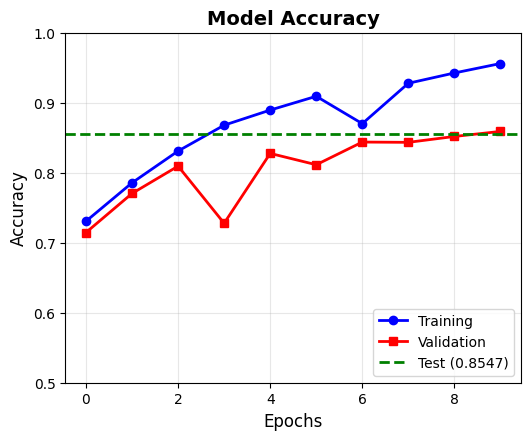

In [64]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 3, 5)


plt.plot(epochs, epoch_train_acc, 'b-', label='Training', linewidth=2, marker='o')
plt.plot(epochs, epoch_valid_acc, 'r-', label='Validation', linewidth=2, marker='s')
plt.axhline(y=test_accuracy, color='g', linestyle='--', label=f'Test ({test_accuracy:.4f})', linewidth=2)


plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')


plt.grid(True, alpha=0.3)
plt.ylim([0.5, 1.0])


plt.show()

## Summary

This RNN implementation successfully achieves **85.47% accuracy** on IMDB sentiment classification using:

- **LSTM architecture** for capturing sequential dependencies
- **Word embeddings** for semantic representation
- **Proper text preprocessing** with vocabulary management
- **Packed sequences** for efficient variable-length processing

**Potential improvements:**
- Regularization techniques (dropout, weight decay)
- Bidirectional LSTM
- Attention mechanisms
- Pre-trained embeddings (Word2Vec, GloVe)
- Learning rate scheduling